In [1]:
from utils import assign_free_gpus
assign_free_gpus()

import time
import json
from pathlib import Path
from sklearn.datasets import make_moons
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn.functional as F
import pytorch_lightning as pl

from generate_data import MoonsDataModule, MoonsDataset
from models import LinearClassifier, GAN_confidence

torch.manual_seed(0)
np.random.seed(0)
rng = np.random.default_rng(0)
path_results = Path.cwd().parent / 'results'

Using GPU(s): 0,1


In [2]:
noise = 0.3
path_classifier = path_results / 'classifier' / '2022-12-06_163615_linear_noise0.3' / 'checkpoints' / 'epoch=99-step=6300.ckpt'
path_gan = path_results / 'GAN_confidence' / '2022-12-06_165906_confidenceTCP_noise0.3' / 'checkpoints' / 'epoch=99-step=12600.ckpt'

# noise = 0.1
# path_classifier = path_results / 'classifier' / '2022-11-29_152904_linear_noise0.1' / 'checkpoints' / 'epoch=99-step=6300.ckpt'
# path_gan = path_results / 'GAN_confidence' / '2022-12-06_170033_confidenceTCP_noise0.1' / 'checkpoints' / 'epoch=99-step=12600.ckpt'

In [3]:
classifier = LinearClassifier.load_from_checkpoint(str(path_classifier))
gan = GAN_confidence.load_from_checkpoint(str(path_gan), classifier=classifier)

data_test = MoonsDataset(n_samples=10000, noise=noise, random_state=2)
x_test = data_test.x
y_test = data_test.y

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8487499952316284
        val_loss            0.3368380665779114
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[None]

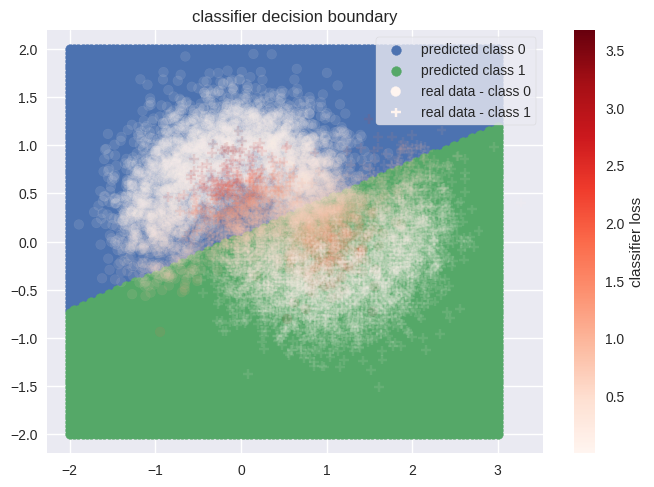

In [4]:
trainer = pl.Trainer(accelerator='auto', devices=1)
trainer.validate(classifier, datamodule=MoonsDataModule(n_samples=20000, noise=noise, random_state=2))

# SHOW DESCISION BOUNDARY
x = np.linspace(-2, 3, 100)
y = np.linspace(-2, 2, 100)

grid_data = np.zeros((len(x)*len(y), 2))
i = 0
for x_ in x:
    for y_ in y:
        grid_data[i] = [x_, y_]
        i += 1
grid_data = torch.from_numpy(grid_data).float()

with torch.no_grad():
    y = classifier(grid_data)
class_pred = torch.sigmoid(y).round().cpu().flatten()#.numpy()

# SHOW CLASSIF LOSS
with torch.no_grad():
    logits = classifier(x_test).squeeze()
    classif_loss = F.binary_cross_entropy_with_logits(logits, y_test, reduction='none')


fig, ax = plt.subplots()
ax.set_title('classifier decision boundary')
ax.scatter(grid_data[class_pred==0, 0], grid_data[class_pred==0, 1], alpha=1, c='C0', label='predicted class 0')
ax.scatter(grid_data[class_pred!=0, 0], grid_data[class_pred!=0, 1], alpha=1, c='C1', label='predicted class 1')
ax.scatter(x_test[y_test==0, 0], x_test[y_test==0, 1], alpha=0.1, c=classif_loss[y_test==0], cmap='Reds', marker='o', label='real data - class 0')
im = ax.scatter(x_test[y_test==1, 0], x_test[y_test==1, 1], alpha=0.1, c=classif_loss[y_test==1], cmap='Reds', marker='+', label='real data - class 1')
leg = ax.legend(frameon=True)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
cbar = fig.colorbar(im, ax=ax, label='classifier loss')
cbar.solids.set(alpha=1)

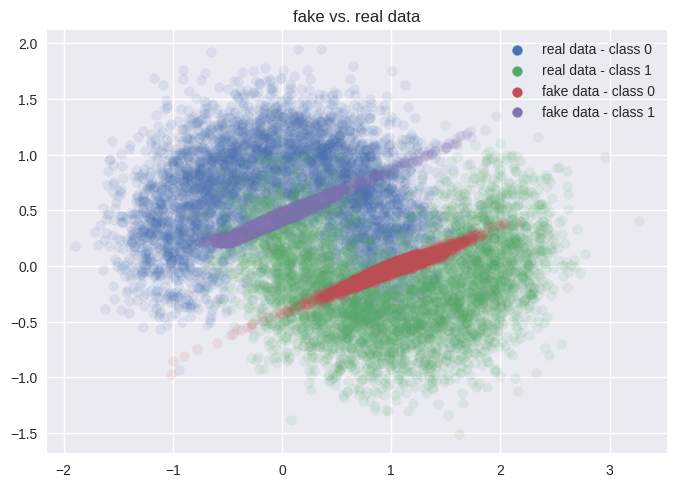

In [5]:
n_samples = len(x_test)
z = torch.randn(n_samples, gan.latent_dim, device=gan.device)
if gan.c_dim > 0:
    rnd_label = torch.randint(gan.c_dim, size=(z.shape[0],), device=gan.device)
    c = F.one_hot(rnd_label, num_classes=gan.c_dim)
    confidence = 0.2*torch.ones((n_samples, 1), device=gan.device)
    # confidence = torch.rand((n_samples, 1), device=gan.device)
    z = torch.cat([z, c, confidence], dim=1)
with torch.no_grad():
    w = gan.generator.mapping(z)
    x_fake = gan.generator.synthesis(w).detach().cpu().numpy()
    rnd_label = rnd_label.cpu().numpy()
    w = w.detach().cpu().numpy()

plt.figure()
plt.title('fake vs. real data')
plt.scatter(x_test[y_test==0, 0], x_test[y_test==0, 1], alpha=0.1, c='C0', label='real data - class 0')
plt.scatter(x_test[y_test==1, 0], x_test[y_test==1, 1], alpha=0.1, c='C1', label='real data - class 1')
plt.scatter(x_fake[rnd_label==0, 0], x_fake[rnd_label==0, 1], alpha=0.1, c='C2', label='fake data - class 0')
plt.scatter(x_fake[rnd_label==1, 0], x_fake[rnd_label==1, 1], alpha=0.1, c='C3', label='fake data - class 1')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# w_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(w)
# plt.figure()
# plt.title('t-SNE in W')
# plt.scatter(w_embedded[rnd_label==0, 0], w_embedded[rnd_label==0, 1], alpha=0.5, c='C0', label='class 0')
# plt.scatter(w_embedded[rnd_label==1, 0], w_embedded[rnd_label==1, 1], alpha=0.5, c='C1', label='class 1')
# plt.legend()

[None]

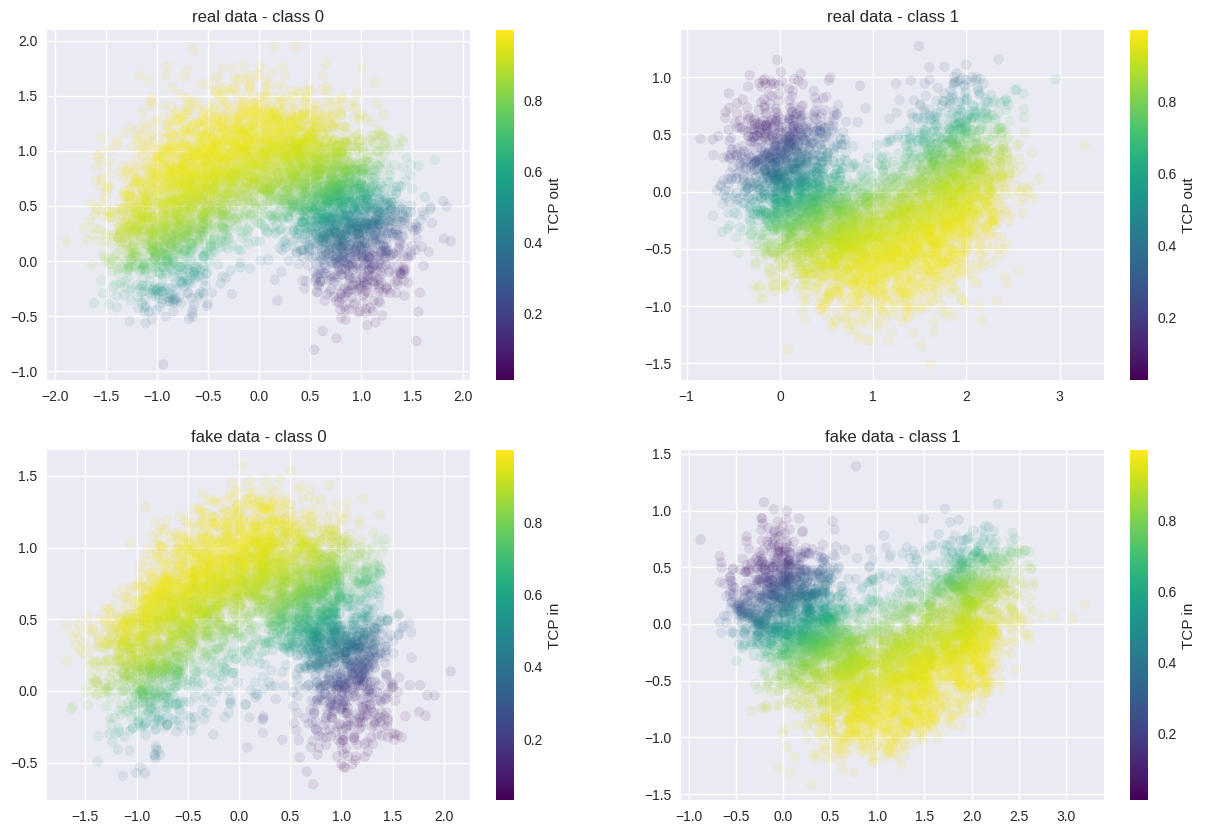

In [6]:
# Get classifier TCP on real data
with torch.no_grad():
    logits = classifier(x_test)
y = torch.sigmoid(logits).squeeze()
tcp = torch.zeros_like(y)
tcp[y_test==0] = 1 - y[y_test==0]
tcp[y_test==1] = y[y_test==1]

# Generate fake data conditioned by class and TCP
n_samples = len(x_test)
z = torch.randn(n_samples, gan.latent_dim, device=gan.device)
if gan.c_dim > 0:
    rnd_label = torch.randint(gan.c_dim, size=(z.shape[0],), device=gan.device)
    c = F.one_hot(rnd_label, num_classes=gan.c_dim)
    # confidence = 0.2*torch.ones((n_samples, 1), device=gan.device)
    # confidence = torch.rand((n_samples, 1), device=gan.device)
    confidence = tcp[torch.randperm(tcp.shape[0])].unsqueeze(1)
    z = torch.cat([z, c, confidence], dim=1)
with torch.no_grad():
    w = gan.generator.mapping(z)
    x_fake = gan.generator.synthesis(w).detach().cpu().numpy()
    rnd_label = rnd_label.cpu().numpy()
    w = w.detach().cpu().numpy()


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.set_title('real data - class 0')
im = ax1.scatter(x_test[y_test==0, 0], x_test[y_test==0, 1], alpha=0.1, c=tcp[y_test==0], cmap='viridis', label='real data - class 0')
cbar = fig.colorbar(im, ax=ax1, label='TCP out')
cbar.solids.set(alpha=1)

ax2.set_title('real data - class 1')
im = ax2.scatter(x_test[y_test==1, 0], x_test[y_test==1, 1], alpha=0.1, c=tcp[y_test==1], cmap='viridis', label='real data - class 1')
cbar = fig.colorbar(im, ax=ax2, label='TCP out')
cbar.solids.set(alpha=1)

ax3.set_title('fake data - class 0')
im = ax3.scatter(x_fake[rnd_label==0, 0], x_fake[rnd_label==0, 1], alpha=0.1, c=confidence[rnd_label==0], cmap='viridis', label='fake data - class 0')
cbar = fig.colorbar(im, ax=ax3, label='TCP in')
cbar.solids.set(alpha=1)
    
ax4.set_title('fake data - class 1')
im = ax4.scatter(x_fake[rnd_label==1, 0], x_fake[rnd_label==1, 1], alpha=0.1, c=confidence[rnd_label==1], cmap='viridis')
cbar = fig.colorbar(im, ax=ax4, label='TCP in')
cbar.solids.set(alpha=1)